In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.base
%aimport models.AEFIT5

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
qsh.load(file)


In [52]:
# qsh.shuffle()
# qsh.filter_number_set(15)
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive()

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [ ]:
# qsh.set_null(np.nan)
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive()
# qsh.set_null(np.nan)

## t-SNE Plot

In [ ]:
qsh.set_null(-1)
sne = Htls.tSNE()
# sne.perplexity = 50.
sne.random = 42

ds = qsh[range(0,4000)]
ds = np.concatenate([ds['prel'],ds['te']], axis=1)
# ds = np.array(list(zip(ds['prel'],ds['te'])))
sne(ds)

In [ ]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hsne.tSNE_PlotBokeh()
p.set_model(sne)
p.set_data(qsh, 1000)
p.plot(notebook_url='http://172.17.0.2:8888')

## VAE reconstruction - beta

The dropout has been set to 0. ... otherwise it seems to not converge ( tested with 0.4 )
Moreover also beta has been set to 0. ... that corresponds to a deterministic vae

In [4]:
#q_vae = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=30, dprate=0., scale=1, beta=0.000001, geometry=[20,20,10,10])
vae6  = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0., scale=1, beta=0.000001, geometry=[20,20,10,10])
vae30 = models.AEFIT5.AEFIT5(latent_dim=30, feature_dim=30, dprate=0., scale=1, beta=0.000001, geometry=[20,20,10,10])
q_vae = vae30

AEFIT5 ready:
AEFIT5 ready:


In [5]:
ds = qsh.ds_array.map(lambda x,l: (x,x))

In [ ]:
#models.base.manual_train_thread(q_vae, qsh, batch=200, epoch=6, loss_factor=1e-3)
# q_vae.train_thread(qsh, batch=200, epoch=10, learning_rate=1e-3).control_panel()
# models.base.train_thread(q_vae, qsh, batch=100, epoch=10, learning_rate=1e-3, callbacks=[]).control_panel()
def fun():
    global h
    h = q_vae.fit( ds.skip(3000).batch(100, drop_remainder=True), validation_data=ds.take(3000).batch(100), 
                   callbacks=[PlotLossesCallback()], 
                   epochs=200, shuffle=False)
models.base.fn_thread(fn=fun, model=q_vae).control_panel()

In [ ]:
def fun():
    global h6
    h6 = vae6.fit( ds.skip(3000).batch(100, drop_remainder=True), validation_data=ds.take(3000).batch(100), 
                   callbacks=[PlotLossesCallback()], 
                   epochs=200, shuffle=False)
models.base.fn_thread(fn=fun, model=vae6).control_panel()

In [ ]:
loss = [i[0] for i in h.history['loss']]
val_loss = [i[0] for i in h.history['val_loss']]
fig = plt.figure('loss')
fig.set_dpi(150)
plt.yscale('log')
plt.plot(loss[0:150])
plt.plot(val_loss[0:150])

In [ ]:
# q_vae.save('step7_beta0_r15_1')
# q_vae.save('step7_beta0001_r15_ls2_1')
# q_vae.save('step7_ls30')
# vae6.save('step7_ls6')

In [6]:
# q_vae.load('step7_beta0_r15_1')
# q_vae.load('step7_beta0001_r15_ls2_1')
q_vae.load('step7_ls30')
vae6.load('step7_ls6')

In [7]:
# extract few points curve
import copy

qsh2 = Dataset_QSH.Dataset_QSH()
qsh2.load(ipysh.abs_builddir+'/te_db_r15u.npy')
qsh2.dim = 15
qsh2.set_null(np.nan)
qsh2.set_normal_positive()
# qsh2.unbias_mean(0.5, 'te')
# qsh2.set_normal_positive()
qsh2.set_null(np.nan)
# qsh2.clip_values(0.1,0.6)
# qsh2.set_normal_positive()

qsh2.filter_number_set(10)
qsh2.dim = 15




In [57]:
pos = 39

221


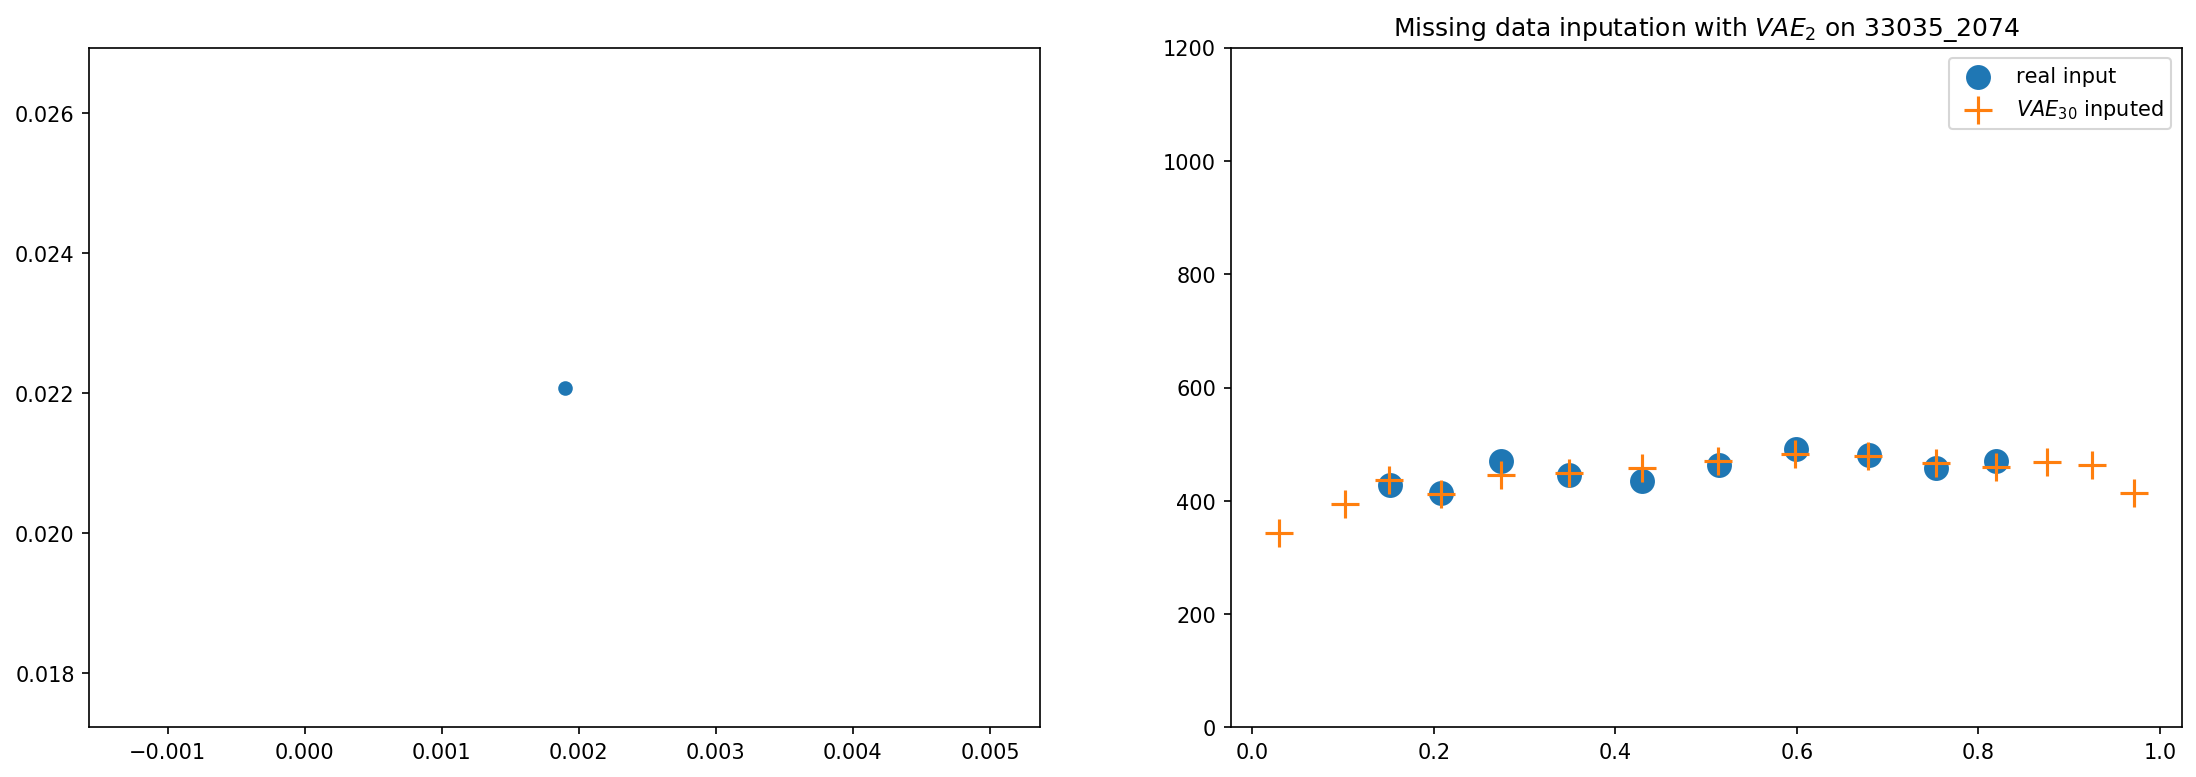

In [334]:
def un(x, min=0, max=2242.511, bias=1.): 
    return bias * min + x*(max-min)


fig = plt.figure('gen_missing_curve',figsize=(18, 6))
fig.set_dpi(150)
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
# ax2.set_ylim(0.,0.5)
ax2.set_ylim(0.,1200.)

# print(q_vae.apply_sigmoid)
print(pos)
# qsh2.shuffle()
for xy in qsh2.ds_array.skip(pos).batch(1).take(1):
    ax2.set_title('Missing data inputation with $VAE_2$ on %s'%qsh2[pos].label.decode("utf-8") )
    xy,_ = xy
    # print(xy)
    x,y = tf.split(xy[0],2)
    ax2.scatter(x,un(y),s=120, label='real input')
    m,v  = q_vae.encode(xy, training=False)    
    gpt = m[0].numpy()
    # print(gpt)
    ax1.scatter(gpt[0],gpt[1])

    XY = q_vae.decode(m, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())

    ax2.scatter(X,un(Y),s=180, marker='+', label='$VAE_{30}$ inputed')
    ax2.legend()
pos += 1


# Caracterization of error

In [41]:
# extract few points curve
import copy
qsh3 = Dataset_QSH.Dataset_QSH()
qsh3.load(ipysh.abs_builddir+'/te_db_r15u.npy')
qsh3.dim = 15
qsh3.set_null(np.nan)


qsh3.set_normal_positive()
qsh3.set_null(np.nan)
qsh3.filter_number_set(15)
qsh3.dim = 15


In [78]:
## Generator of missing positions at random ##
def mask(x, n):
    x = tf.convert_to_tensor(x)
    xnan = np.ones(15)
    for i in range(n): xnan[i]=np.nan
    np.random.shuffle(xnan)
    return x, tf.convert_to_tensor(np.concatenate([xnan,xnan]), dtype=tf.float32)

def mask_y(x, n):
    x = tf.convert_to_tensor(x)
    xnan = np.ones(15)
    xones = np.ones(15)
    for i in range(n): xnan[i]=np.nan
    np.random.shuffle(xnan)
    return x, tf.convert_to_tensor(np.concatenate([xones,xnan]), dtype=tf.float32)

ds2 = qsh3.ds_array.map(lambda x,y: mask(x,2) )
x,n = [x for x in ds2.batch(1).take(1)][0]
tf.math.is_nan(x*n)

<tf.Tensor: id=956114, shape=(1, 30), dtype=bool, numpy=
array([[False, False, False, False, False,  True, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True, False, False,
        False, False, False]])>

In [298]:
def UN(x, min=0, max=2242.511, bias=1.): 
    x,y = tf.split(x, 2)
    y = bias * min + y*(max-min)
    return tf.concat([x,y], axis=1)

# def un(x, min=te_min, max=te_max): return min + x*(max-min)
err = [ Htls.Stat2() for _ in range(15) ]
for _ in range(10):
    for i in range(15):
        ds2 = qsh3.ds_array.map(lambda x,y: mask_y(x,i) ).take(100).batch(10)
        for q in ds2:
            q,n = q
            x = q_vae.call(q*n, training=False)
            e  = tf.keras.losses.mse(UN(x),UN(q))
            for e in e: err[i] += np.sqrt(e.numpy())


In [299]:
err6 = [ Htls.Stat2() for _ in range(15) ]
for _ in range(10):
    for i in range(15):
        ds2 = qsh3.ds_array.map(lambda x,y: mask_y(x,i) ).take(100).batch(10)
        for q in ds2:
            q,n = q
            x = vae6.call(q*n, training=False)
            e  = tf.keras.losses.mse(UN(x),UN(q))
            for e in e: err6[i] += np.sqrt(e.numpy())


500


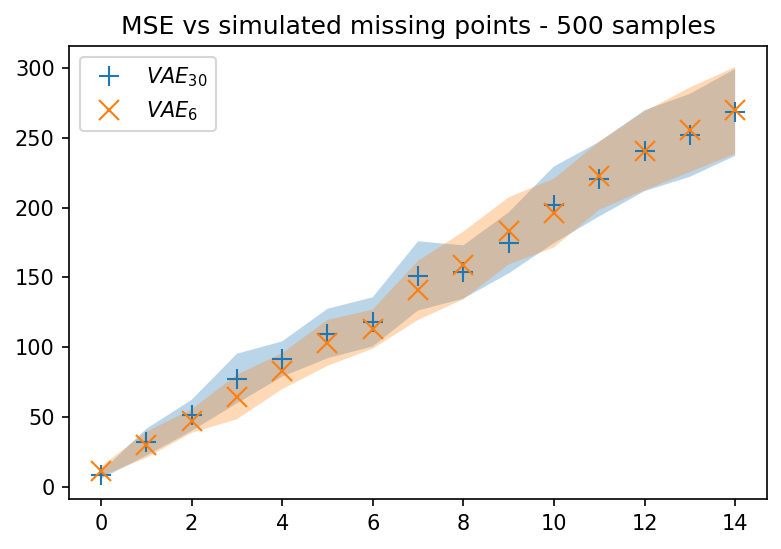

In [300]:
count = err[0].m_count
print(count)

m = np.array([ x.mean() for x in err ])
v = np.array([ x.rms() for x in err ])
m6 = np.array([ x.mean() for x in err6 ])
v6 = np.array([ x.rms() for x in err6 ])

def clip(x): return np.clip(x, a_min=0., a_max=1e10)

fig = plt.figure('err')
ax = plt.gca()
fig.set_dpi(150)
x = range(15)
ax.set_title('MSE vs simulated missing points - %d samples'%err[0].m_count)
plt.plot(m, '+', markersize=10, label='$VAE_{30}$')
plt.fill_between(x, clip(m+v), clip(m-v), alpha=0.3)
plt.plot(m6, 'x', markersize=10, label='$VAE_{6}$')
plt.fill_between(x, clip(m6+v6), clip(m6-v6), alpha=0.3)
#  ax.grid()
plt.legend()

224
for xy in qsh3.ds_array.skip(pos).map(lambda x,y: mask(x,i) ).batch(1).take(1):

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
for xy in qsh3.ds_array.skip(pos).map(lambda x,y: mask(x,i) ).batch(1).take(1):

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.


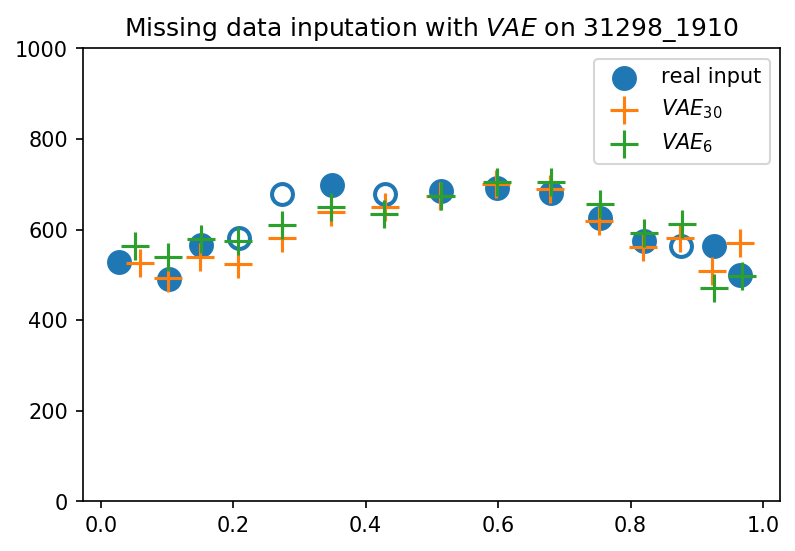

In [337]:


fig = plt.figure('gen_missing_curve')
fig.set_dpi(150)
plt.clf()
ax = plt.gca()
ax.set_ylim(0.,1e3)

# print(q_vae.apply_sigmoid)
print(pos)
i = 4
# qsh2.shuffle()
for xy in qsh3.ds_array.skip(pos).map(lambda x,y: mask(x,i) ).batch(1).take(1):
    ax.set_title('Missing data inputation with $VAE$ on %s'%qsh3[pos].label.decode("utf-8") )
    xy,n = xy
    x,y   = tf.split(xy[0],2)
    _,yn = tf.split(n[0],2)
    yn = tf.where(tf.math.is_nan(yn),tf.ones_like(yn), tf.convert_to_tensor(np.full(tf.shape(yn),np.nan), dtype=tf.float32))
    ax.scatter(x,un(y),s=120, label='real input')
    ax.scatter(x,un(y*yn),s=50, c='white')
    #     XY  = q_vae.recover(xy*n)
    #     XY6 = vae6.recover(xy*n)
    XY  = q_vae.call(xy*n, training=False)
    XY6 = vae6.call(xy*n, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    ax.scatter(X,un(Y),s=180, marker='+', label='$VAE_{30}$')
    X,Y = tf.split(XY6[0], 2)
    X,Y = (X.numpy(), Y.numpy())    
    ax.scatter(X,un(Y),s=180, marker='+', label='$VAE_{6}$')
    ax.legend()
pos += 1

# CLEAN DATABASE

In [ ]:
## CLEAN QSH DATABASE
import copy
from tqdm import tqdm
qsh_clean = copy.deepcopy(qsh)

print( q_vae.apply_sigmoid )

ds = qsh.ds_array
for i,X in enumerate(tqdm(ds.batch(1), total=len(qsh))):
    X,_ = X
    s   = int(q_vae.feature_dim/2)
    Xr  = q_vae.recover(X)
    x,y = tf.split(Xr, 2, axis=1)
    qsh_clean[i].prel[:s] = x
    qsh_clean[i].te[:s]   = y

    


In [ ]:
qsh_clean.save(ipysh.abs_builddir+'/te_db_r15_clean.npy')

In [ ]:
qsh_clean = Htls.QSH_Dataset()
qsh_clean.load(ipysh.abs_builddir+'/te_db_r15_clean.npy')
qsh_clean.dim = 15
qsh_clean.set_null(np.nan)

## TSNE on clean

In [ ]:
qsh_clean.set_null(-1)
sne = Htls.tSNE()
# sne.perplexity = 50.
sne.random = 42

ds = qsh_clean[0:2000]
ds = np.concatenate([ds['prel'],ds['te']], axis=1)
sne(ds)

In [ ]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hsne.tSNE_PlotBokeh()
p.set_model(sne)
p.set_data(qsh_clean, 1000)
p.plot(notebook_url='http://172.17.0.2:8888')

# CONVOLUTIONAL VAE

In [ ]:
cae = models.CAEFIT.CAEFIT(latent_dim=2, feature_dim=30, dprate=0., scale=2, beta=0.)

# im1 = tf.keras.utils.plot_model(cae.inference_net, show_shapes=True, rankdir='LR')
# im2 = tf.keras.utils.plot_model(cae.generative_net, show_shapes=True, rankdir='LR')
# from IPython.display import display
# display(im1)
# display(im2)

In [ ]:
cae = models.CAEFIT1.CAEFIT1(latent_dim=2, feature_dim=30, dprate=0., scale=2, beta=0.)

In [ ]:
ds = qsh_clean.ds_array
ds0,_ = [x for x in ds.take(1).batch(1)][0]
ds0
me,va = cae.encode(ds0)
y = cae.decode(me, apply_sigmoid=True)
y

In [ ]:
# train(cae, qsh_clean, batch=200, epoch=10, loss_factor=1e-4)
# models.base.train(cae, qsh_clean, batch=200, epoch=2, loss_factor=1e-3)
models.base.train(cae, qsh_clean, batch=200, epoch=2, loss_factor=1e-3)

In [ ]:
models.base.train_thread(cae, qsh_clean, batch=200, epoch=5, learning_rate=1e-3).control_panel()

In [ ]:
# ipysh.Bootstrap_support.debug()

p = Hplt.LSPlotBokeh()
p.set_model(cae)
p.set_data(qsh_clean, counts=1000)
p.plot_notebook(notebook_url='http://172.17.0.2:8888')

In [ ]:
# cae.save('step7_cae_r15')

In [ ]:
cae.load('step7_cae_r15')

In [ ]:
qsh_pos = 0

In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)


for xy in qsh_clean.ds_array.skip(qsh_pos).take(1):    
    xy,_ = xy
    x,y = tf.split(xy,2)
    ax2.scatter(x,y,s=80)
    m,v  = cae.encode([xy], training=False)
    gpt = m[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = cae.decode(m,apply_sigmoid=True, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1
